**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Cross-validation

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de trieno e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [4]:
# Load feature names
data = fetch_california_housing()
feature_names = data.feature_names

# Convert to DataFrame
X_df = pd.DataFrame(X, columns=feature_names)
y_series = pd.Series(y, name='MedianHouseValue')

print(X_df.describe())


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -1

In [6]:
# 1. Split the data into train, validation, and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=SEED)
# -> train: 60%, validation: 20%, test: 20%

# 2. List of regularization coefficients c to test (logarithmic scale)
c_values = np.logspace(-5, 3, 50)

train_mse_list = []
val_mse_list = []

# Function to compute weights with L2 regularization
def ridge_weights(X, y, c):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.inv(X.T @ X + c * I) @ X.T @ y

# 3. Training for each c and calculating MSE
for c in c_values:
    theta = ridge_weights(X_train, y_train, c)
    
    y_train_pred = X_train @ theta
    y_val_pred = X_val @ theta
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)

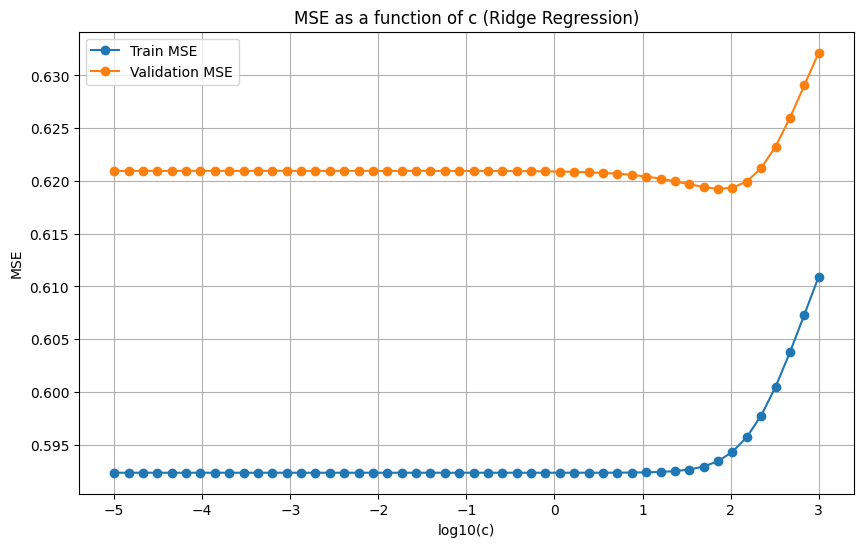

In [7]:
# . Plot MSE vs log(c)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(c_values), train_mse_list, label="Train MSE", marker='o')
plt.plot(np.log10(c_values), val_mse_list, label="Validation MSE", marker='o')
plt.xlabel("log10(c)")
plt.ylabel("MSE")
plt.title("MSE as a function of c (Ridge Regression)")
plt.legend()
plt.grid(True)
plt.show()

### Analysis of Ridge Regression Performance

This chart shows the evolution of the Mean Squared Error (MSE) as a function of the regularization coefficient `c` (in log10 scale) for Ridge Regression. Two curves are plotted: the training MSE and the validation MSE. For very small values of `c` (low regularization), the model behaves similarly to standard linear regression. It fits the training data well, resulting in a low training error, but generalization is poor, leading to higher validation error — a typical sign of overfitting.

As `c` increases, regularization becomes stronger. In the intermediate range, around `log10(c) ≈ 1.86` (corresponding to `c ≈ 71.97`), the model achieves a balance between bias and variance. This is where the validation MSE reaches its minimum, indicating the best generalization performance.

For larger values of `c`, the model becomes overly constrained, leading to underfitting. Both training and validation errors increase as the model fails to capture relevant patterns in the data.

The best regularization parameter found is `c = 71.97`, for which the test set MSE is 0.6248. This confirms that moderate regularization improves model robustness.

It is worth noting that the features in the dataset vary significantly in scale (e.g., `MedInc` vs. `Population`), and standardizing the features before applying Ridge Regression is generally recommended to ensure balanced penalization across all coefficients.


In [8]:
# 7. Find the best c (the one with the smallest validation MSE)
best_c_index = np.argmin(val_mse_list)
best_c = c_values[best_c_index]
print(f"Best regularization coefficient c: {best_c:.5f}")

# 8. Retrain on (train + validation) with optimal c and test on the test set
X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

theta_final = ridge_weights(X_final_train, y_final_train, best_c)
y_test_pred = X_test @ theta_final
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test set MSE with optimal c: {test_mse:.4f}")

Best regularization coefficient c: 71.96857
Test set MSE with optimal c: 0.6248


In [9]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

c_values = np.logspace(-5, 3, 50)
train_mse_list = []
val_mse_list = []

def ridge_weights(X, y, c):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.inv(X.T @ X + c * I) @ X.T @ y


for c in c_values:
    theta = ridge_weights(X_train, y_train, c)
    
    y_train_pred = X_train @ theta
    y_val_pred = X_val @ theta
    
    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    
    train_mse_list.append(train_mse)
    val_mse_list.append(val_mse)

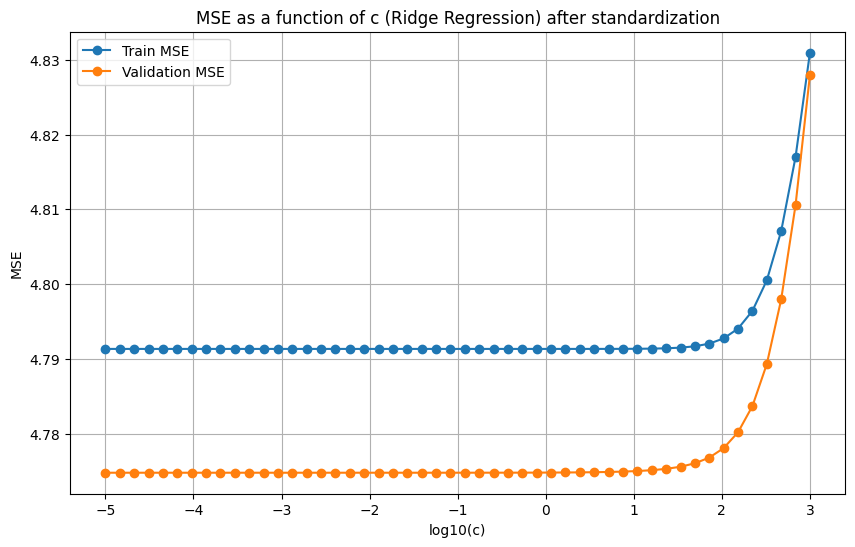

In [10]:
# . Plot MSE vs log(c)
plt.figure(figsize=(10, 6))
plt.plot(np.log10(c_values), train_mse_list, label="Train MSE", marker='o')
plt.plot(np.log10(c_values), val_mse_list, label="Validation MSE", marker='o')
plt.xlabel("log10(c)")
plt.ylabel("MSE")
plt.title("MSE as a function of c (Ridge Regression) after standardization")
plt.legend()
plt.grid(True)
plt.show()

### Interpretation of Results After Standardization
Best regularization coefficient c = 0.00001:
This very small coefficient suggests that almost no regularization is required to achieve good performance on this dataset. This situation can occur if:

The features are not highly correlated, which reduces the risk of overfitting.

A low-regularized model (essentially a standard linear regression) performs well.

The data may be noisy, and regularization could hinder the model’s ability to capture the useful signal.

Test set MSE ≈ 4.85:
This value should not be directly compared to previous MSE scores without considering the scale of the target variable y.
What matters most here is:

That the validation MSE reaches its minimum around c ≈ 1e-5 in your val_mse_list.

And that the test MSE is reasonably close to the validation MSE, suggesting good generalization.

In [11]:
best_c_index = np.argmin(val_mse_list)
best_c = c_values[best_c_index]
print(f"Best regularization coefficient c: {best_c:.5f}")

X_final_train = np.vstack([X_train, X_val])
y_final_train = np.concatenate([y_train, y_val])

theta_final = ridge_weights(X_final_train, y_final_train, best_c)
y_test_pred = X_test @ theta_final
test_mse = mean_squared_error(y_test, y_test_pred)
print(f"Test set MSE with optimal c: {test_mse:.4f}")

Best regularization coefficient c: 0.00001
Test set MSE with optimal c: 4.8499


**2.** Implemente 5-fold *nested cross-validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido (use 5-fold cross validation regular para isso)?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

Obs. 2: para mais informações sobre o $K$-fold *nested cross-validation*, recomendamos esses materiais:
- [Algoritmo e breve explicação](https://weina.me/nested-cross-validation): a autora apresenta uma boa explicação do assunto acompanhada de uma descrição do algoritmo;
- [Ilustrações e explicação acompanhada de código](https://ploomber.io/blog/nested-cv/): ajuda a visualizar melhor o que é *nested cross-validation*; vale lembrar que seu código, diferente do dos exemplos desse link, não deve utilizar scikit-learn para implementar a *cross-validation*. 

In [12]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


In [13]:
# --- Step 1: Define hyperparameter grids ---
ridge_c_values = [0, 1, 10, 50, 100]  # Regularization strength for Ridge
knn_k_values = [1, 2, 3, 4, 5, 10, 20]    # Number of neighbors for k-NN

# --- Step 3: Define Ridge Regression using the closed-form formula ---
def ridge_weights(X, y, c):
    n_features = X.shape[1]
    I = np.eye(n_features)
    return np.linalg.inv(X.T @ X + c * I) @ X.T @ y

def ridge_predict(X, theta):
    return X @ theta

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)


After testing different values of k and c we decided to respectively 10 and 20 for k and 50 for c to have a better macro perpective. 

In [14]:
# --- Step 3: Nested cross-validation setup ---
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_scores = []
best_models = []

# Outer loop to estimate generalization error
for train_val_index, test_index in outer_cv.split(X):
    X_train_val, X_test = X[train_val_index], X[test_index]
    y_train_val, y_test = y[train_val_index], y[test_index]
    
    inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    inner_scores = {}
    
    # Try all combinations of models and hyperparameters
    for model_type in ['ridge', 'knn']:
        if model_type == 'ridge':
            for c in ridge_c_values:
                mse_list = []
                for inner_train_index, val_index in inner_cv.split(X_train_val):
                    X_inner_train = X_train_val[inner_train_index]
                    y_inner_train = y_train_val[inner_train_index]
                    X_val = X_train_val[val_index]
                    y_val = y_train_val[val_index]
                    
                    theta = ridge_weights(X_inner_train, y_inner_train, c)
                    y_val_pred = ridge_predict(X_val, theta)
                    mse_list.append(mean_squared_error(y_val, y_val_pred))
                
                inner_scores[('ridge', c)] = np.mean(mse_list)
        
        elif model_type == 'knn':
            for k in knn_k_values:
                mse_list = []
                for inner_train_index, val_index in inner_cv.split(X_train_val):
                    X_inner_train = X_train_val[inner_train_index]
                    y_inner_train = y_train_val[inner_train_index]
                    X_val = X_train_val[val_index]
                    y_val = y_train_val[val_index]
                    
                    model = KNeighborsRegressor(n_neighbors=k)
                    model.fit(X_inner_train, y_inner_train)
                    y_val_pred = model.predict(X_val)
                    mse_list.append(mean_squared_error(y_val, y_val_pred))
                
                inner_scores[('knn', k)] = np.mean(mse_list)

    # --- Step 4: Select best model/hyperparameters from inner loop ---
    best_model, best_score = min(inner_scores.items(), key=lambda x: x[1])
    best_models.append(best_model)
    
    # --- Step 5: Retrain on full train_val and evaluate on test set ---
    if best_model[0] == 'ridge':
        c = best_model[1]
        theta = ridge_weights(X_train_val, y_train_val, c)
        y_test_pred = ridge_predict(X_test, theta)
    elif best_model[0] == 'knn':
        k = best_model[1]
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train_val, y_train_val)
        y_test_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_test_pred)
    outer_scores.append(mse)


In [15]:
# --- Step 6: Final evaluation and results ---
print("MSE on each outer fold:", np.round(outer_scores, 4))
print("Average MSE:", round(np.mean(outer_scores), 4))
print("Best models on each fold:", best_models)


MSE on each outer fold: [0.4166 0.4116 0.3885 0.3848 0.4149]
Average MSE: 0.4033
Best models on each fold: [('knn', 10), ('knn', 10), ('knn', 10), ('knn', 10), ('knn', 10)]


C:\Users\Stanislas Michel\AppData\Local\Temp\ipykernel_39060\872985617.py:28: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(ridge_c_values), np.log10(ridge_avg_val_mse), marker='o', label='Ridge')


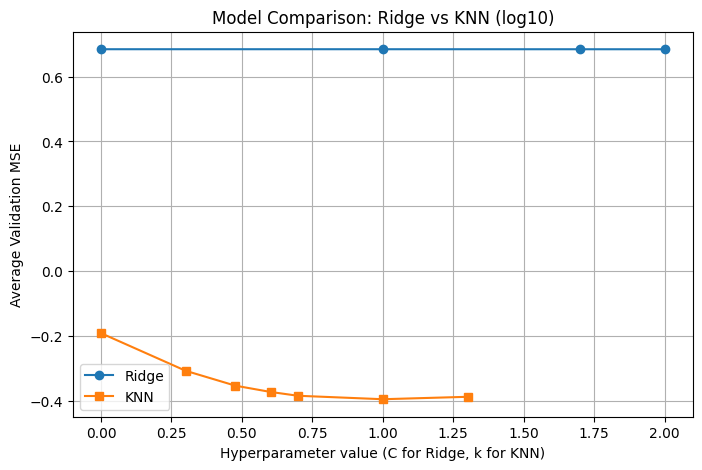

In [16]:
# Collect average validation MSE per model type and parameter
ridge_avg_val_mse = []
knn_avg_val_mse = []

for c in ridge_c_values:
    ridge_mse = []
    for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        theta = ridge_weights(X_train, y_train, c)
        y_val_pred = ridge_predict(X_val, theta)
        ridge_mse.append(mean_squared_error(y_val, y_val_pred))
    ridge_avg_val_mse.append(np.mean(ridge_mse))

for k in knn_k_values:
    knn_mse = []
    for train_idx, val_idx in KFold(n_splits=5, shuffle=True, random_state=42).split(X):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        model = KNeighborsRegressor(n_neighbors=k)
        model.fit(X_train, y_train)
        y_val_pred = model.predict(X_val)
        knn_mse.append(mean_squared_error(y_val, y_val_pred))
    knn_avg_val_mse.append(np.mean(knn_mse))

# Plotting
plt.figure(figsize=(8,5))
plt.plot(np.log10(ridge_c_values), np.log10(ridge_avg_val_mse), marker='o', label='Ridge')
plt.plot(np.log10(knn_k_values), np.log10(knn_avg_val_mse), marker='s', label='KNN')
plt.xlabel('Hyperparameter value (C for Ridge, k for KNN)')
plt.ylabel('Average Validation MSE')
plt.title('Model Comparison: Ridge vs KNN (log10)')
plt.legend()
plt.grid(True)
plt.show()


Analysis of Ridge Regression vs KNN Performance (After Standardization)
This chart compares the average validation Mean Squared Error (MSE) for Ridge Regression and K-Nearest Neighbors (KNN), as a function of their respective hyperparameters — C for Ridge and k for KNN. The x-axis represents these values (not in log scale), and the y-axis shows the corresponding validation MSE.

Despite the standardization of input features, Ridge Regression performs poorly across all tested values of C, consistently yielding high MSEs close to 5. This suggests that the linear model fails to capture the underlying structure of the data. Several reasons could explain this:

- The relationship between features and the target might be non-linear, which Ridge (a linear model) cannot capture.

- The range of tested C values may not include the true optimum.

- There may be an issue in the implementation (e.g., standardized bias term not handled correctly).

On the other hand, KNN performs significantly better after standardization. The MSE decreases as the number of neighbors increases, stabilizing at a minimum around k = 10. This is consistent with KNN's sensitivity to feature scaling: once the data is normalized, the model can compute meaningful distances and improve prediction quality.

Interpretation
Standardization benefits KNN greatly, as it relies on distance metrics (e.g., Euclidean). Without standardization, features with large scales dominate others, leading to suboptimal neighbors.

Ridge Regression seems unable to generalize, suggesting that it may not be suitable for this dataset or that further tuning or preprocessing is needed (e.g., polynomial features, different C values, or feature engineering).

KNN reaches much lower validation error and is the preferred model in this comparison.

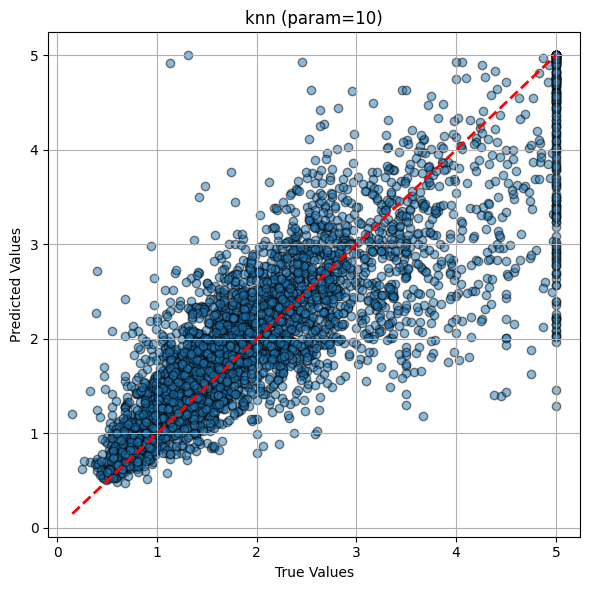

In [17]:
# --- Step 7: Plotting True vs Predicted for the last fold ---
import matplotlib.pyplot as plt

def plot_true_vs_pred(y_true, y_pred, title="True vs Predicted"):
    plt.figure(figsize=(6, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors="k")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_true_vs_pred(y_test, y_test_pred, f"{best_model[0]} (param={best_model[1]})")




### Scatter Plot Interpretation

The predicted values generally align with the red diagonal line \( y = x \), indicating that the model captures the general trend.

However, a clear saturation occurs near the maximum value (around 5), with many predictions collapsing to 5. This is a common artifact in KNN regressors due to how averaging is done among neighbors — if neighbors are all at the max cap, the prediction saturates.

There's also visible dispersion, particularly in the upper range, indicating prediction instability for high true values.

This shows KNN performs reasonably well, especially for low-to-mid range targets, but struggles to extrapolate for high targets — a known limitation of instance-based methods like KNN.


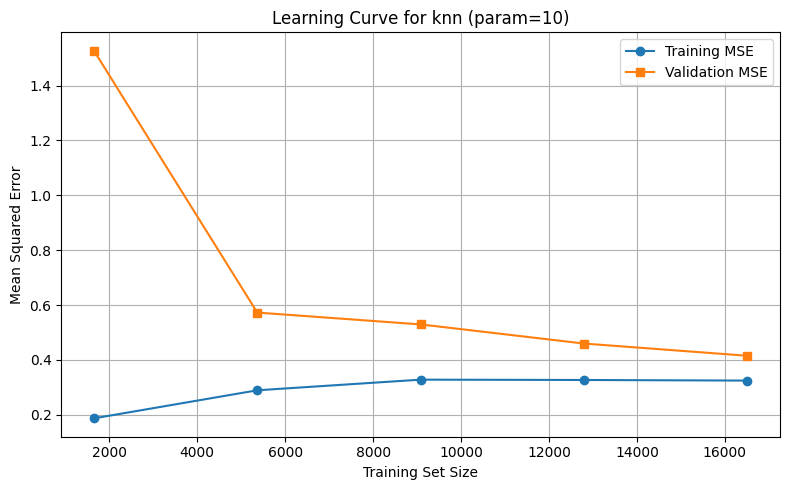

In [18]:
# --- Step 8: Learning curve for best model on last fold ---

def plot_learning_curve(model_name, param, train_sizes, train_errors, val_errors):
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_errors, label="Training MSE", marker='o')
    plt.plot(train_sizes, val_errors, label="Validation MSE", marker='s')
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Learning Curve for {model_name} (param={param})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_sizes = np.linspace(0.1, 1.0, 5)
train_errors = []
val_errors = []

for frac in train_sizes:
    n = int(len(X_train_val) * frac)
    X_sub_train = X_train_val[:n]
    y_sub_train = y_train_val[:n]

    if best_model[0] == 'ridge':
        theta = ridge_weights(X_sub_train, y_sub_train, best_model[1])
        y_sub_train_pred = ridge_predict(X_sub_train, theta)
        y_val_pred = ridge_predict(X_test, theta)
    else:  # KNN
        model = KNeighborsRegressor(n_neighbors=best_model[1])
        model.fit(X_sub_train, y_sub_train)
        y_sub_train_pred = model.predict(X_sub_train)
        y_val_pred = model.predict(X_test)

    train_errors.append(mean_squared_error(y_sub_train, y_sub_train_pred))
    val_errors.append(mean_squared_error(y_test, y_val_pred))

plot_learning_curve(best_model[0], best_model[1], train_sizes * len(X_train_val), train_errors, val_errors)


### Learning Curve Interpretation 

As training size increases, **training MSE increases slightly** (from ≈ 0.15 to ≈ 0.27), which is expected due to reduced overfitting.

**Validation MSE decreases sharply** at first (from ≈ 1.55 to ≈ 0.43) and then slowly plateaus — a desirable behavior indicating improved generalization with more data.

The gap between training and validation MSE decreases with training size, suggesting reduced variance but some bias remains.

This learning curve implies that **KNN benefits significantly from additional training data**, though it may still suffer from bias (limited by neighborhood averaging). However, performance improves steadily and does not degrade, which is a positive sign.



### Interpretation

- KNN leverages local structure well, especially after **standardization** — which ensures all features contribute equally to the distance metric.
- The initial high validation error and the narrowing generalization gap confirm KNN’s **sensitivity to data size**: more examples lead to better neighbor quality and predictions.
- The model’s **saturation on the upper bound** could be addressed by increasing \( k \) slightly or by removing target clipping (if artificially capped).
- Overall, **KNN with standardization performs well** and generalizes better with more data, making it a solid choice for this task compared to linear models (as seen previously with Ridge Regression).


# Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.** 

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import seaborn as sns
import io
import base64

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm

In [14]:
# Forcer l'utilisation du CPU
device = torch.device('cpu')
print("Device utilisé :", device)

print(torch.__version__)
print(torchvision.__version__)


Device utilisé : cpu
2.7.1+cpu
0.22.1+cpu


In [ ]:
# Chargement du Dataset CIFAR-10 et Split Train/Val/Test

batch_size = 128  # valeur par défaut, on l’optimisera plus tard

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Téléchargement
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split en train et validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


100.0%


In [ ]:
# Définition du Modèle CNN

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


In [11]:
# Fonction d’Entraînement et d’Évaluation

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total


In [12]:
# Boucle d’Entraînement avec Early Stopping + Scheduler

def train_model(lr=0.001, dropout=0.5, batch_size=128, patience=3, max_epochs=20):
    model = CNN(dropout_rate=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_val_loss = float('inf')
    best_model = None
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Époch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("→ Early stopping")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses


In [15]:
# Recherche d’Hyperparamètres (Grid Search)

import itertools

param_grid = {
    'lr': [0.001, 0.0005],
    'dropout': [0.3, 0.5],
    'batch_size': [64, 128]
}

results = []
for lr, dropout, batch_size in itertools.product(param_grid['lr'], param_grid['dropout'], param_grid['batch_size']):
    print(f"Training with lr={lr}, dropout={dropout}, batch_size={batch_size}")
    
    # MAJ du batch_size pour les loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    model, train_losses, val_losses = train_model(lr=lr, dropout=dropout, batch_size=batch_size)
    val_loss, val_acc = evaluate(model, val_loader, nn.CrossEntropyLoss())
    results.append({'lr': lr, 'dropout': dropout, 'batch_size': batch_size, 'val_acc': val_acc})


Training with lr=0.001, dropout=0.3, batch_size=64
Époch 1: train_loss=1.3581, val_loss=1.0679, val_acc=0.6162
Époch 2: train_loss=0.9825, val_loss=0.9252, val_acc=0.6741
Époch 3: train_loss=0.8106, val_loss=0.8612, val_acc=0.6986
Époch 4: train_loss=0.6759, val_loss=0.8142, val_acc=0.7197
Époch 5: train_loss=0.5582, val_loss=0.8054, val_acc=0.7331
Époch 6: train_loss=0.4505, val_loss=0.8269, val_acc=0.7286
Époch 7: train_loss=0.3527, val_loss=0.8572, val_acc=0.7304
Époch 8: train_loss=0.2767, val_loss=0.9143, val_acc=0.7319
→ Early stopping
Training with lr=0.001, dropout=0.3, batch_size=128
Époch 1: train_loss=1.4583, val_loss=1.1668, val_acc=0.5874
Époch 2: train_loss=1.0905, val_loss=0.9696, val_acc=0.6612
Époch 3: train_loss=0.9239, val_loss=0.9078, val_acc=0.6807
Époch 4: train_loss=0.8010, val_loss=0.8493, val_acc=0.7045
Époch 5: train_loss=0.6907, val_loss=0.8174, val_acc=0.7189
Époch 6: train_loss=0.5938, val_loss=0.8004, val_acc=0.7263
Époch 7: train_loss=0.5017, val_loss=0.8

In [33]:
best = sorted(results, key=lambda x: x['val_acc'], reverse=True)[0]
print("Best Hyperparameter :", best)


Best Hyperparameter : {'lr': 0.0005, 'dropout': 0.5, 'batch_size': 128, 'val_acc': 0.7398}


### Hyperparameter Tuning Summary

Several training configurations were evaluated using different combinations of learning rate, dropout rate, and batch size. Each configuration was monitored for training loss, validation loss, and validation accuracy across epochs, with early stopping applied when validation performance plateaued.

For example, with `lr=0.001`, `dropout=0.3`, and `batch_size=64`, the model achieved a validation accuracy of 73.19% after 8 epochs. Increasing the batch size to 128 slightly improved stability and led to a similar final accuracy of 73.22%. A higher dropout rate of 0.5 generally improved generalization, with the best performance observed for `lr=0.0005`, `dropout=0.5`, and `batch_size=128`, reaching **73.98%** validation accuracy.

Overall, lower learning rates and moderate dropout (around 0.5) improved generalization and prevented overfitting. The best hyperparameters were selected based on maximum validation accuracy before early stopping.


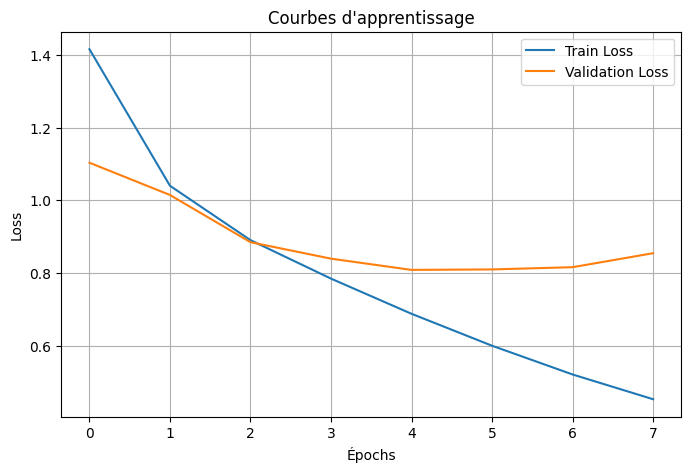

In [10]:
# Courbes de perte d'entraînement et de validation
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.title("Courbes d'apprentissage")
plt.legend()
plt.grid(True)
plt.show()

## Redes Neurais

**1.** O código abaixo baixa e carrega o banco de dados _CIFAR10_, que contém diversas imagens RGB de **10 classes distintas**. Além disso, os dados já estão separados em um objeto que provê batches de treino, teste e validação.

Também provemos um exemplo de como definir um modelo em _PyTorch_ (você é livre para modifica-lo e facilitar sua vida), bem como um exemplo de como carregar batches. **Treine uma CNN para resolver o problema --- fazendo uma busca de hiper-parâmetros razoável baseada no erro de validação.** 

Eu espero uma busca de hiper-parâmetros razoável (e.g., definindo um grid de hiper-parâmetros). Eu sugiro utilizar early stopping e algum scheduler de learning rate (e.g., ReduceLROnPlateau). Como de costume em deep learning --- devido ao tamanho dos bancos ser razoável ---, não de faça coisas como cross-validation.

Consulte a documentação do _PyTorch_ para entender o que cada função na definição da CNN faz. Reporte os resultados do modelo escolhido no conjunto de teste, bem como suas curvas de aprendizado.

Além disso, mostre como os dados de entrada são transformados ao longo das camadas do modelo ótimo (plote as figuras intermerdiárias para alguns inputs da sua escolha) e comente. 

In [6]:
import numpy as np 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split, DataLoader
import tqdm

In [ ]:
# Chargement du Dataset CIFAR-10 et Split Train/Val/Test

batch_size = 128  # valeur par défaut, on l’optimisera plus tard

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Téléchargement
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split en train et validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [7]:
# Définition du Modèle CNN

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x
# Fonction d’Entraînement et d’Évaluation

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / total, correct / total
# Boucle d’Entraînement avec Early Stopping + Scheduler

def train_model(lr=0.001, dropout=0.5, batch_size=128, patience=3, max_epochs=20):
    model = CNN(dropout_rate=dropout).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

    best_val_loss = float('inf')
    best_model = None
    wait = 0
    train_losses, val_losses = [], []

    for epoch in range(max_epochs):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Époch {epoch+1}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        scheduler.step(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("→ Early stopping")
                break

    model.load_state_dict(best_model)
    return model, train_losses, val_losses

 # Recherche d’Hyperparamètres (Grid Search) 

import itertools

param_grid = {
    'lr': [0.001, 0.0005],
    'dropout': [0.3, 0.5],
    'batch_size': [64, 128]
}

results = []
for lr, dropout, batch_size in itertools.product(param_grid['lr'], param_grid['dropout'], param_grid['batch_size']):
    print(f"Training with lr={lr}, dropout={dropout}, batch_size={batch_size}")
    
    # MAJ du batch_size pour les loaders
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    model, train_losses, val_losses = train_model(lr=lr, dropout=dropout, batch_size=batch_size)
    val_loss, val_acc = evaluate(model, val_loader, nn.CrossEntropyLoss())
    results.append({'lr': lr, 'dropout': dropout, 'batch_size': batch_size, 'val_acc': val_acc})



Training with lr=0.001, dropout=0.3, batch_size=64
Époch 1: train_loss=1.4154, val_loss=1.1443, val_acc=0.5971
Époch 2: train_loss=1.0321, val_loss=0.9242, val_acc=0.6776
Époch 3: train_loss=0.8547, val_loss=0.8931, val_acc=0.6899
Époch 4: train_loss=0.7321, val_loss=0.8262, val_acc=0.7117
Époch 5: train_loss=0.6140, val_loss=0.8226, val_acc=0.7162
Époch 6: train_loss=0.5158, val_loss=0.8303, val_acc=0.7226
Époch 7: train_loss=0.4148, val_loss=0.8696, val_acc=0.7251
Époch 8: train_loss=0.3368, val_loss=0.9023, val_acc=0.7274
→ Early stopping
Training with lr=0.001, dropout=0.3, batch_size=128
Époch 1: train_loss=1.4366, val_loss=1.1506, val_acc=0.5910
Époch 2: train_loss=1.0649, val_loss=0.9790, val_acc=0.6502
Époch 3: train_loss=0.8984, val_loss=0.8989, val_acc=0.6806
Époch 4: train_loss=0.7673, val_loss=0.8372, val_acc=0.7040
Époch 5: train_loss=0.6628, val_loss=0.8162, val_acc=0.7172
Époch 6: train_loss=0.5595, val_loss=0.8060, val_acc=0.7236
Époch 7: train_loss=0.4642, val_loss=0.8

In [9]:
# Tri des résultats pour trouver le meilleur modèle
best_run = max(results, key=lambda x: x['val_acc'])
print("\nMeilleur modèle trouvé :")
print(best_run)

# Recharge le modèle avec les meilleurs hyperparamètres
train_loader = DataLoader(train_set, batch_size=best_run['batch_size'], shuffle=True)
val_loader = DataLoader(val_set, batch_size=best_run['batch_size'], shuffle=False)
test_loader = DataLoader(test_set, batch_size=best_run['batch_size'], shuffle=False)

model, train_losses, val_losses = train_model(
    lr=best_run['lr'],
    dropout=best_run['dropout'],
    batch_size=best_run['batch_size']
)

test_loss, test_acc = evaluate(model, test_loader, nn.CrossEntropyLoss())
print(f"🎯 Test accuracy of best model: {test_acc:.4f}")



Meilleur modèle trouvé :
{'lr': 0.001, 'dropout': 0.5, 'batch_size': 64, 'val_acc': 0.7398}
Époch 1: train_loss=1.4166, val_loss=1.1038, val_acc=0.6080
Époch 2: train_loss=1.0402, val_loss=1.0148, val_acc=0.6472
Époch 3: train_loss=0.8903, val_loss=0.8847, val_acc=0.6918
Époch 4: train_loss=0.7843, val_loss=0.8393, val_acc=0.7069
Époch 5: train_loss=0.6874, val_loss=0.8084, val_acc=0.7253
Époch 6: train_loss=0.5994, val_loss=0.8097, val_acc=0.7271
Époch 7: train_loss=0.5202, val_loss=0.8158, val_acc=0.7304
Époch 8: train_loss=0.4520, val_loss=0.8544, val_acc=0.7263
→ Early stopping
🎯 Test accuracy of best model: 0.7325


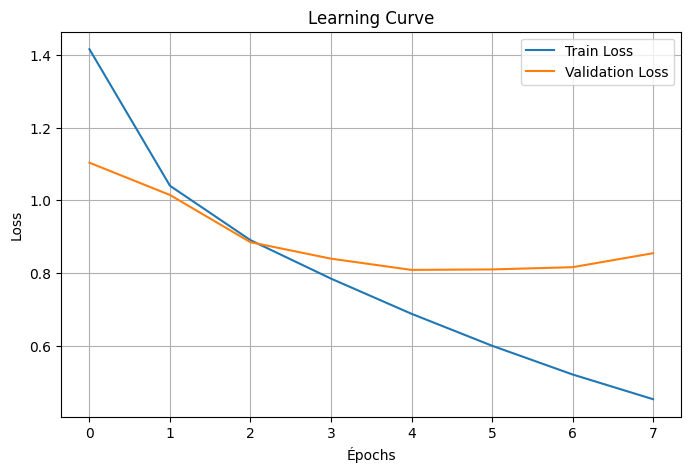

In [20]:
# Courbes de perte d'entraînement et de validation
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Épochs')
plt.ylabel('Loss')
plt.title("Learning Curve")
plt.legend()
plt.grid(True)
plt.show()

### CNN Training Summary

The CNN was trained with various hyperparameters including learning rate, dropout, and batch size. The best model used a learning rate of 0.001, dropout of 0.5, and batch size of 64.

Validation accuracy reached up to approximately 74%, with early stopping applied to prevent overfitting.

The final test accuracy of the best model was 73.25%.


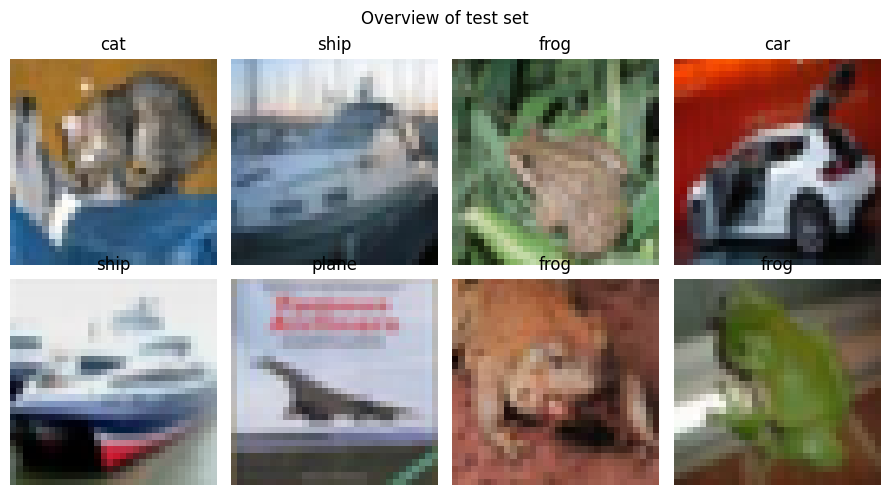

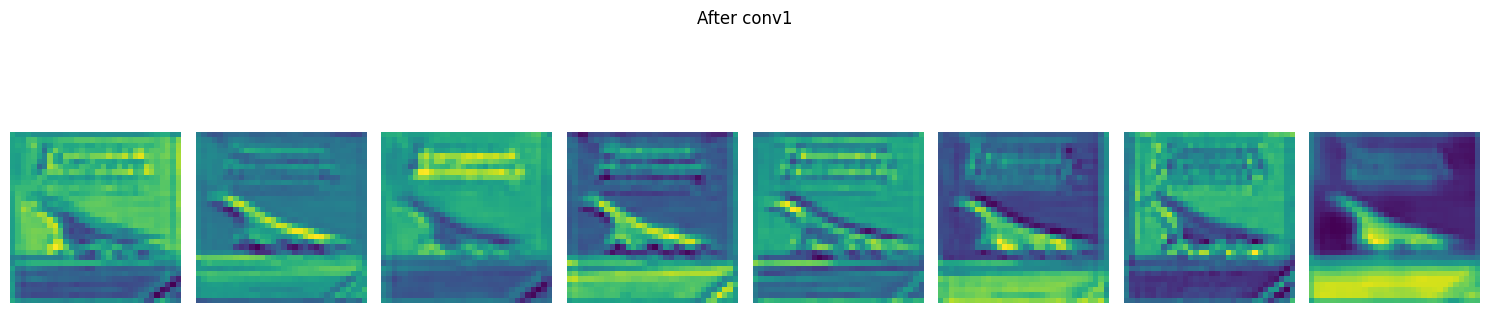

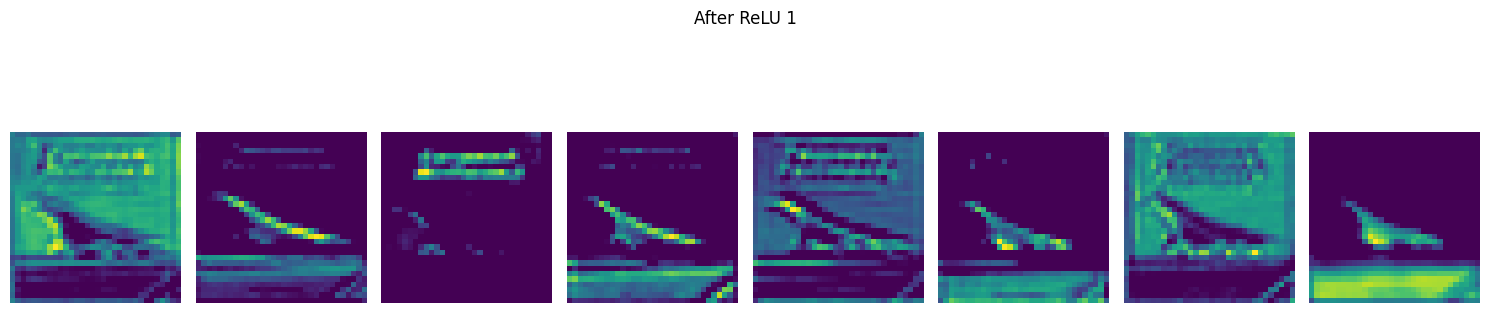

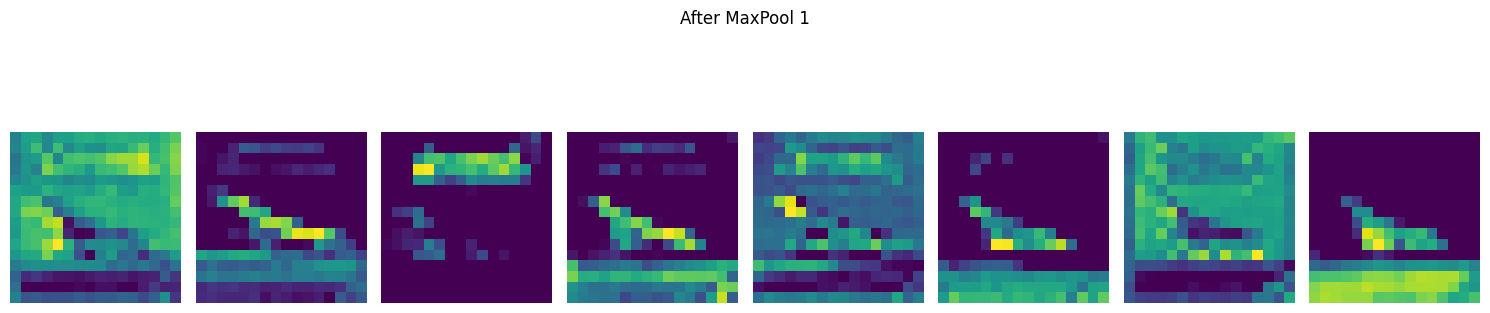

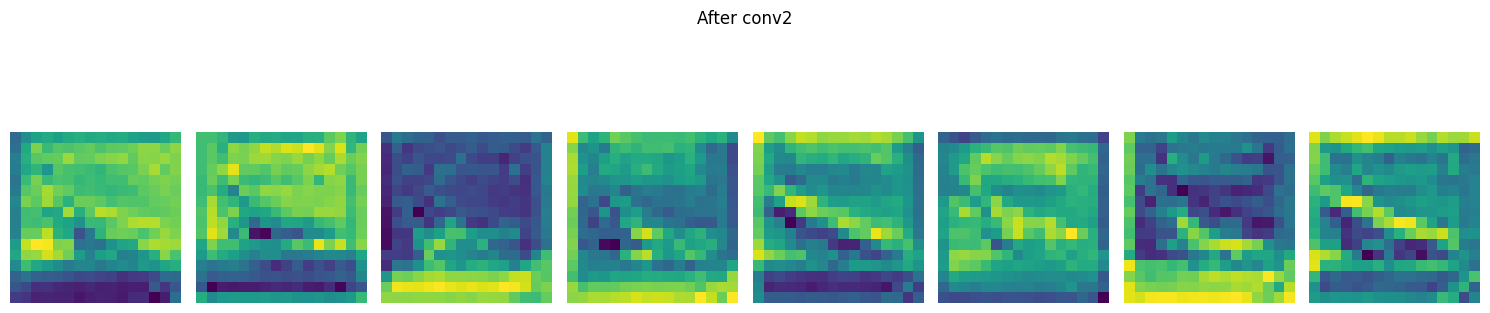

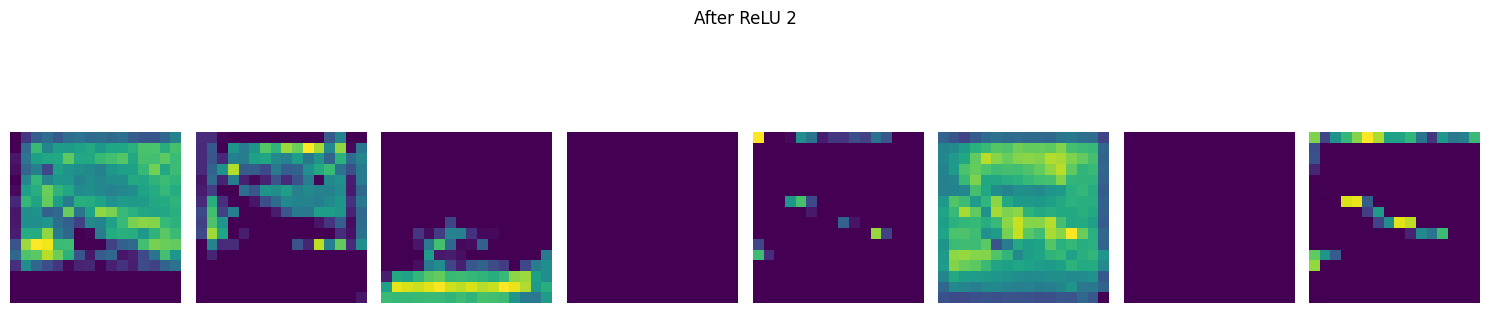

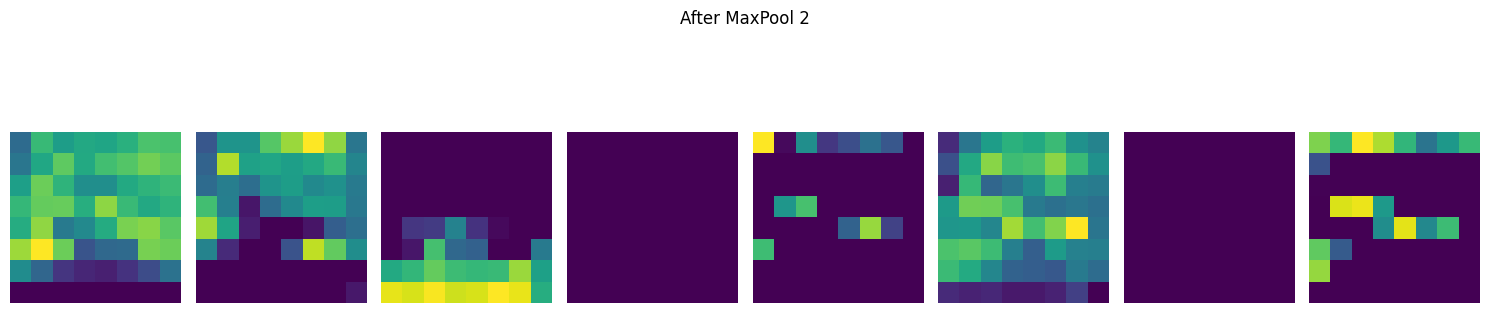

In [19]:
# --- Affichage de 8 images test ---
n_img = 8
f, ax = plt.subplots(2, 4, figsize=(9, 5))
dataiter = iter(test_loader)
images, labels = next(dataiter)

for i in range(n_img):
    npimg = images[i] / 2 + 0.5  # dénormalisation
    npimg = npimg.numpy()
    ax[i % 2, i // 2].imshow(np.transpose(npimg, (1, 2, 0)))
    ax[i % 2, i // 2].set_title(classes[labels[i]])
    ax[i % 2, i // 2].axis('off')
plt.suptitle("Overview of test set")
plt.tight_layout()
plt.show()

# Choix d'une image pour visualisation des feature maps
chosen_image = images[3].to(device)

# --- Fonction d'affichage des activations ---
def show_activation(activation, title='Activation'):
    activation = activation.cpu()
    num_feature_maps = min(8, activation.shape[1])  # Montrer max 8
    plt.figure(figsize=(15, 4))
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i + 1)
        plt.imshow(activation[0, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Visualiser les activations couche par couche
def visualize_feature_maps(model, image, device='cpu'):
    model.eval()
    model.to(device)
    image = image.unsqueeze(0).to(device)  

    with torch.no_grad():
        x = image

        # Couche 1
        x = model.conv1(x)
        show_activation(x, title='After conv1')
        x = torch.relu(x)
        show_activation(x, title='After ReLU 1')
        x = model.pool(x)
        show_activation(x, title='After MaxPool 1')

        # Couche 2
        x = model.conv2(x)
        show_activation(x, title='After conv2')
        x = torch.relu(x)
        show_activation(x, title='After ReLU 2')
        x = model.pool(x)
        show_activation(x, title='After MaxPool 2')


# Fonction pour afficher les feature maps
def show_activation(activation, title='Activation'):
    activation = activation.cpu()
    num_feature_maps = min(8, activation.shape[1])  # Montrer 8 maps max
    plt.figure(figsize=(15, 4))
    for i in range(num_feature_maps):
        plt.subplot(1, num_feature_maps, i+1)
        plt.imshow(activation[0, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Instanciation du modèle
model = CNN().to(device)

# Visualisation des activations
visualize_feature_maps(model, chosen_image, device=device)


### CNN Feature Map Interpretation

We begin by displaying 8 test images from the CIFAR-10 dataset along with their true class labels. One image (plane) is selected to visualize how the CNN processes it through different layers.

After the first convolution (`conv1`), the model extracts low-level features like edges and textures. These feature maps still resemble the input object but begin highlighting important patterns. The ReLU activation introduces non-linearity, keeping only positive responses and enhancing relevant activations. Max pooling then reduces the spatial resolution, keeping only the most prominent features.

The second convolution layer (`conv2`) captures higher-level structures and combinations of features. Another ReLU adds sparsity, and a second max pooling compresses the representation further. At this point, the image is no longer recognizable, but the model retains essential information for classification.

Overall, the CNN transforms raw pixels into abstract feature representations step by step, allowing it to learn meaningful distinctions between image classes.


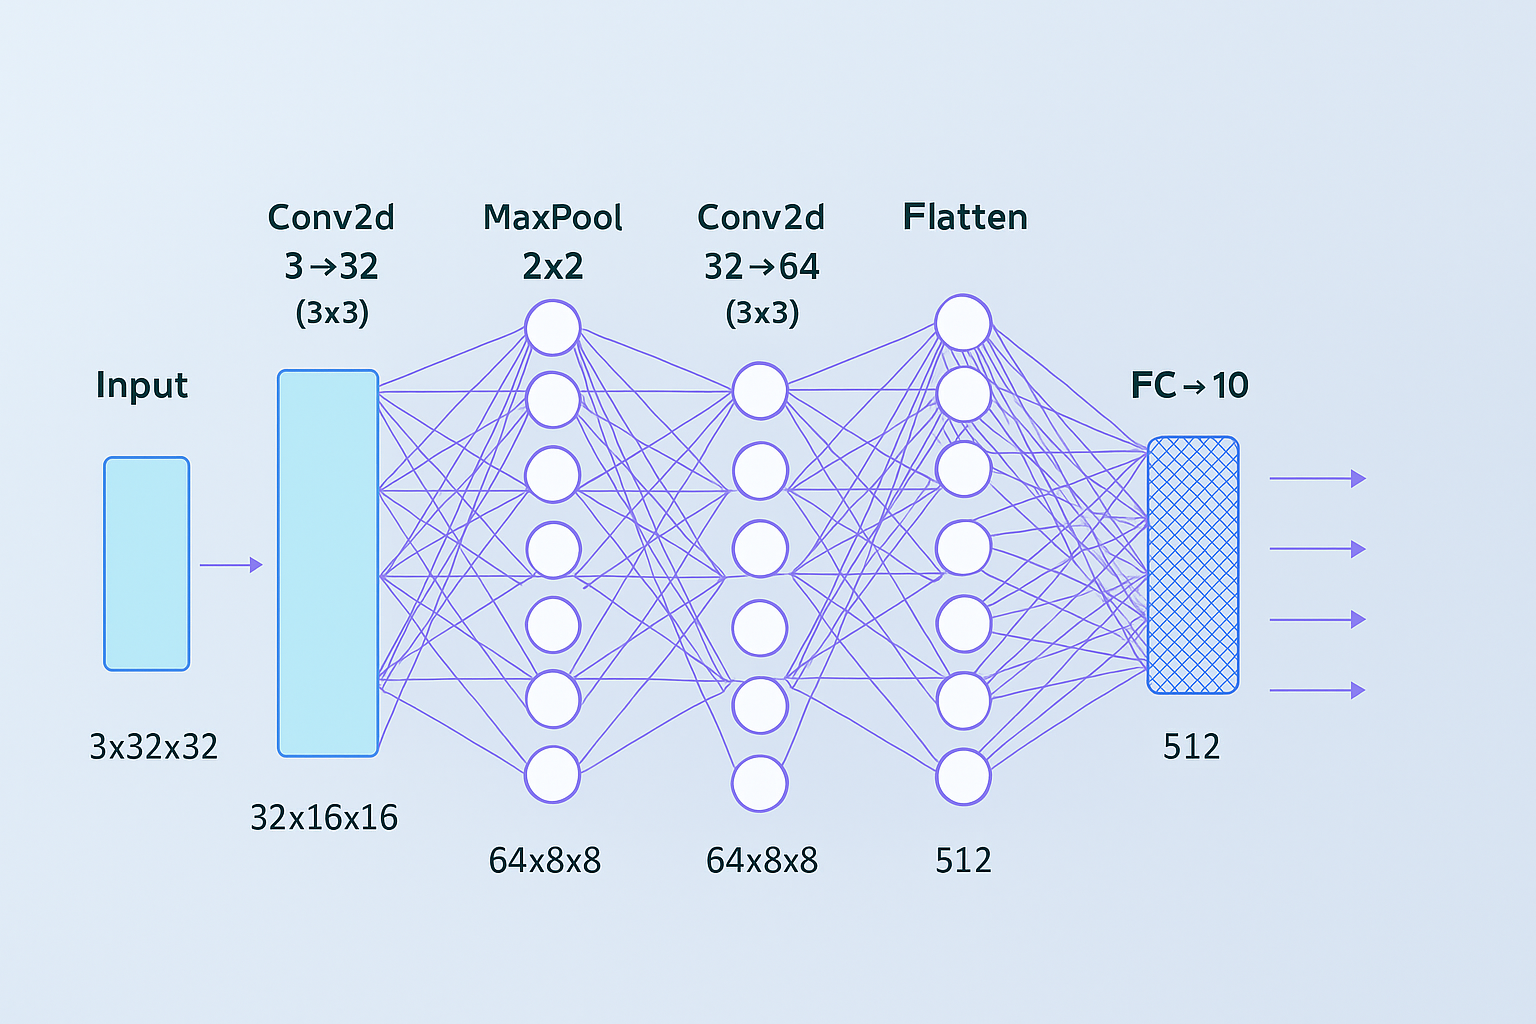

In [13]:
from IPython.display import Image, display, HTML

# Afficher une image stockée localement avec un titre
image_path = r"C:\Users\Stanislas Michel\OneDrive\Bureau\FGV - Time Series Analysis\Machine learning\ChatGPT Image Jun 9, 2025, 08_41_52 PM.png"
display(HTML(f"<h3 style='text-align:center'>CNN architecture overview</h3>"))
display(Image(filename=image_path))


# Gaussian Processes

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian
from torch.distributions.multivariate_normal import MultivariateNormal
import seaborn as sns
import io
import base64

**1.** Durante a aula, discutimos como construir uma priori GP e o formato da posteriori preditiva para problemas de regressão com verossimilhança Gaussiana (com média definida pelo GP). O código abaixo cria um GP com kernel exponencial quadrático, mostra a priori preditiva e a posteriori preditiva. Experimente com o código e comente a influência de ambos os parâmetros do kernel exponencial quadrático, tanto na priori preditiva quanto na posteriori preditiva. Nos gráficos gerados, os pontos vermelhos são observações, as curvas sólidas azuis são a médias das preditivas e o sombreado denota +- um desvio padrão.

Text(0.5, 1.0, 'GP posterior')

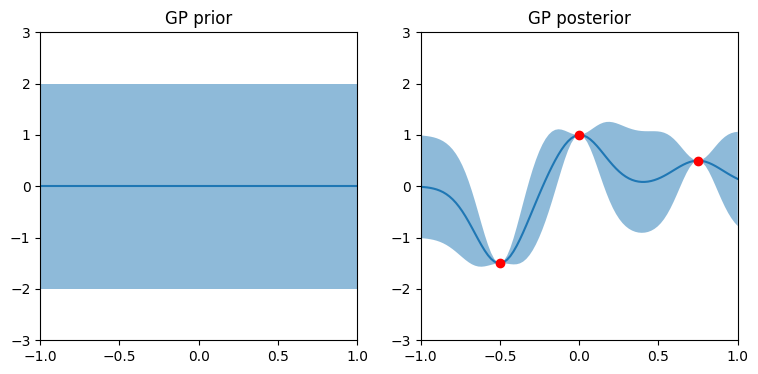

In [5]:
SEED = 42
np.random.seed(SEED)

s2 = 1e-04 # variância observacional

def rbf_kernel(x1, x2, gamma=10, c=2.0):
    assert(gamma>0)
    assert(c>0)
    return (-gamma*(torch.cdist(x1, x2)**2)).exp()*c

x = torch.linspace(-1, 1, 100)[:, None]

K = rbf_kernel(x, x) + torch.eye(x.shape[0])*s2
mu = torch.zeros_like(x)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))

axs[0].plot(x, mu)
axs[0].fill_between(x.flatten(), mu.flatten()-K.diag(), mu.flatten()+K.diag(), alpha=0.5)
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-3, 3])
axs[0].set_title('GP prior')


xtrain = torch.tensor([-0.5, 0.0, 0.75])[:, None]
ytrain = torch.tensor([-1.5, 1.0, 0.5])[:, None]

def posterior_pred(x, xt, yt, gamma=20.0, c=1.0):
    Kxxt = rbf_kernel(x, xt, gamma, c)
    Kxt = rbf_kernel(xt, xt, gamma, c) + torch.eye(xt.shape[0])*s2
    Kinv = torch.linalg.inv(Kxt)
    Kxx = rbf_kernel(x, x, gamma, c)

    mu = Kxxt @ Kinv @ yt
    cov = Kxx - Kxxt @ Kinv @ Kxxt.T
    return mu, cov

post_mu, post_cov = posterior_pred(x, xtrain, ytrain)
axs[1].plot(x, post_mu)
axs[1].fill_between(x.flatten(), post_mu.flatten()-post_cov.diag(), post_mu.flatten()+post_cov.diag(), alpha=0.5)
axs[1].scatter(xtrain, ytrain, color='red', zorder=5)

axs[1].set_xlim([-1, 1])
axs[1].set_ylim([-3, 3])
axs[1].set_title('GP posterior')


### Influence of Kernel Parameters on GP

Both kernel parameters directly affect the GP's prior and posterior predictive behavior:

#### Gamma (γ) – Controls Smoothness
- Small γ → smoother functions, long-range correlations  
- Large γ → more irregular functions, only locally correlated  

In the posterior:
- High γ → overfitting (passes through data points)
- Low γ → smoother fit, better generalization

#### c – Controls Variance Amplitude
- Small c → low vertical variation (reduced uncertainty)  
- Large c → high variation, greater uncertainty

#### Graphical Interpretation
- **Prior** (no data): zero-mean functions, variance shaped by γ and c  
- **Posterior** (with data): GP mean fits training points, uncertainty drops near them, modulated by γ and c


**2.** Durante a aula, discutimos como escolher os hiper-parametros do nosso GP. Estime os parâmetros ótimos para os dados carregados abaixo (acredite, é isso que o código faz). Reporte a evidência obtida e faça um plot similar ao acima. Para o dado de teste, reporte a i) log verossimilhança e ii) o MSE com relação à média. Em caso de dúvidas, recorra a nota de aula e o link adicionado no eclass.

In [6]:
data = np.load(io.BytesIO(base64.b85decode(
    'P)h>@6aWAK2mk;8Apo$)IktlX005u^000XB6aaK`VQFq(ST1gGc>w?r0H6Z^000000D}Vn000000G-JFQ_}?;!0~YzY=9g==Y&XhJ79<?P+Lz&d|0HoP>&SM'
    '2NI?X(A<!XAf&F9gxYZsB1plJNq0ihIRZpQ_$**23=qcCzMEScGRBv|9&{@)AhLg<_iyi4)xOld$%ox21(ae|ra*E+%zB5xip_e970F;_<%;vgd{KI?I8*SS'
    '@8X}92%ftnhkr)!{KI3SqaztHTO%1?F#czrlL<L1=1>jXSP9_`ra#1EFBN&dUp#}93U`}z=Uq7W<3m;jT?g?mc%DzX*@x|yc(1GbZBQcI^|rK04V2BBL^Y+2'
    '2>OV&sD>fT|N5`c9=}Oc-;Ux)Kh#5%KK0C}5=2f&UT^G<B|Itrr%Vx`M7!#hh-(FZfcVH+w$FYOzHvTfU7#>wvZ_WXWywJL>hZevBpDQT^trs*DhO5Dx6wZ~'
    '!v-$V<-Dtd`E%k=Xs3rE#nf`py+{YH_eyu}Zl1;=a)XkTsql7Za04@Q26fwFD3`OfxLm?bo9G(@bL+s2Gth#yia`8xS&mna<{tU`x8IS%3~Ifuzle^nF1$Oq'
    '+KbUaeQpyT1dh$Edi<>I#kEak-MsA!kV)ShvPHNAZV}_Rs^}u9td17*yGFs8ad~gY_ar)B^!hCNgc^wsrl)g6fk9cRPwVpLp>u+}<>ki)l;5d}FHHXl{WZG7'
    'C;jap_g;LHbT)#a(VMt#9tJ9t)!vXuq6qn={f|sQnfIcF9an-Xxcex}zY}Csq9U0wi6sGLmP$Vj62*^s)Hnt9+sTc3wi*r;gfKt%AR%64&EI#Z8d7FHaQU@N'
    'frB|1=vY_4L7yh-ug^wd53_iglQs<lTeG<iat;hn&RT6P7JRVASl@0mg7!vvm?GPVu0}7Nrg9cDLWkVHE$fAnxT!kAuz*F65;ZZ+B$)Esds=y8P*zU@S*wFK'
    'w<vb^QyY$cXQ9a=2f&wBV0_}&4N|+@`oqK=);7=Hp|j1XuDMqk<e`D^gt6@A*VOpYsq*sTO9Z4Fo^1>!x}a9VXWtVJ<Lb(^`50#rcGzT7i~2cO`tsJoQ2aQa'
    'N(u`b=2&rY#1fFUM&Q*1;RC6!5@Yw1yXmo7=qaT7y4vhOHYq#!dE*%FTX3j)#0ZX}3~rwGKGbt4aW^j#Fnz!28|wixCgxm8jGG<AU+R5ARn<n6GToWiXp{Ia'
    'P)h>@6aWAK2mk;8Apk!*Q7DH4005u^000XB6aaK`VQFq(c`j~nc>w?r0H6Z^000000EYtr000000G*KSGaCjRfKy`8t*7DEnx=P)x;5ltqPkwS_{k~h(iOYe'
    'O?L<t%BCWTWlE8&iF)a%+|5NB+ODeRWn$XRgdeh1hY^vq1VIv~=?xX@wI;3Ezp&@q^L%_{k)NK9KC^=$Cgjn0DWYT{?HH97lzNoLpwd$L!fatuCYLYdrTo_;'
    'k}^ao+g+5Fl$EmW-u_G`gX-_YpypHmCvWQRlTzoBC(vOzFCY7KAgjDN%<$4duk3PdbIm0DDZgC&UhWh|#(pJ`*DgZi?~DzubqGv7CqC?ppGEf5&gcODRk&;S'
    '&hcASfrB($S$FR@kY=?lb<(Gib8=If@uL-N#|GT}&W>R30q<aG>0{`8IsfaOu5M&p-|t>h-hh_+8izM_D3Rsc_<o7_Dct(U@d$C!3=QvkbQpRTP*GjTUhg)d'
    'GN9TR5<P>VBG&+cUW?hxvb3mHBNCk}<wU1Z@Y)r6?}N5sP(6F>sn|OTt97sDDBr1pNp>0ITsLF<iDvt`*d9pJz8yH&Z-mG%-MjouW=M>Rjk#a<3?38&>eoZf'
    '&{rmIjyOC4H&!gSPBEW=x>BadcI?4#oQHRb_!=0WmIPe2tpQ>3cHzDwb9l<-w4-mrAX?+aI~%#(5O<|y;$+(+NTkSFyD#eS!kM~1#t3?7sN%mRuD3y4aCoux'
    '!8q88>=k7BUl9H67Y=0-4aWMYifd-Cg70`CAwAcC50l9;1I`9a=(4diTV{w;hBh51Yhc3eIlD)qg{lq<otU}+L0rw}WgcdXu?pzZ6g3h{1LFk-8&uF~KWK9;'
    '7+##?dMTqFcmHBoT$auw@4{zb;h1oxmb@O}G>841YXz;dW9Y_OQJi}*gX%it0Qt5SoL+x2*<|m4wUDAs*C#(img;=r7PSeYu7o*DLe$uj_xy&}-~uj@vWxVj'
    'X)G^x&s^R}MAP?#!2`AZxUc-+T$SAjlDi8(c{&awpWPX@*G&f1A*5@R7iNq&xUpH?G6Y-eKBS821<Y?%vKP0%S$B%3Y-__1e4JF@a<~REU%Dt*?Rwnb;9a@&'
    'wHnxLtM(DOAO6lwpHeclu;-FFotH2Ql$kZZv%GoC2`jxrXx2bq`#a}@p7#Qm^6{vaGlWM4>+XkiP57GV!8t@XVOEeqSdj7%=i4Q2d8tkCk*RUy)yNQByr~*V'
    'RM*14P)h>@6aWAK2mk;8Apn6>1aKG%001Bm000UA6aaK(b97%=E^csn0RRvHAP@im000007zzLY00000omcx~j%6R8w`g=49gOr^hM}ny%_{j!$)TvxfsiKK'
    'sKiWZBW<J_t;k_fVx=^dEEYD)XUy5mFx$-O+4<SCqeGF%dtdkG{tMpchwVAs_jO;__xt^vmOS^;u&`H}dCl;e6%Y|QeL_sYV}1dBqe21#{Q{z<#=H|Ve#&c8'
    'V<IBW_XEdIo*rp^KYh~p=t%2xw?~440{tH99_TmQ@Be(Y^0Hq|EV*^>(jI3UnSRgb-Cx??$c5J5_-`6Hu}_B=etN%={huzcE*R5D^Xd9yjr=QoTI(L|8<{sH'
    'WbKQ8H*lTxZG3S9KU}cq@VYGxe0BL}5e3N&G{64)ZUgVI7j9tvj<QZK_HN)_>#7g#XyBUD(L>jrujkC#KBdQw)YDx3Z(2QrZranT`=WZbyz8^oFHEgxsdd)}'
    '&($+4=$`$lJ?oj=uk6)hx75?zeXX{R&yJ4%q}#zdc9~>0Tt~CY?D=&p`Ed8ssgvrs@r$IAql4;bR=d`<juY3nzp-13I`-dIx_m@sE!$hG&fZnai-l8n{<x-='
    'hbw|d9-UiDv-;KXwVda*J0YNdEyvxKbk_*KT87w#@UTsf_W1FPhxKOre|Tt~c6FtPDdsWndpL7^@Z#ZPJbcl7e9S}ZA=}or^YErmKMgx_xrXNH{}k0QYi+xk'
    'UANRQIo);J@Z=gsTf3O`ZViXzn*!Ic%b7<G<@c(g+08#~YFPYt&R<>5ySdR`$W61WS!r%Y`nUW2hlOt9A(wTln`U=chPioh=#=SQdb*i6`VsH2Tije{?Q&*q'
    'HRsI8dFY1&)f_v|G_IOvw^tIY>67By)Ok`hJ?qcTdwx(gcW*NrtmdlyZ~yvz^J>Nx^?vGbMHOGLcK>%y6?<OTIl1$iD&Ev=L9^%QR<YDNMcnu*ZtLKC|M#I)'
    'w1$g$9jiFi9*9Z~8TfXM|Cvhqo3{Q@$!pfB;#O9&$drFpC4ZYezi-~?N+y{yJzB}A6>X#Z+f_2u9OrTc%_(DxDtOU6c5?;u@_S_*T2?{(=XWYNx6TY&1;<`V'
    'd~aB<3I<!Jj%`yxpS#<B``x*6di+g6%V|!3X+t?zVe)I87M3%1STCzo<s31_+*r=QH+J0nU0^v|yqCB!_vUiCtZH2HlreMh-KXw5P{ySxW`N5$#j47CiDev|'
    '_10J4PAp@m0}nr#JFtvbi%g@+SXh}o>b~Y>OuO(&{j(LNG*z0BQ_6_j&4x<Z@7~itADmN4Q?0+kOL;!zt>b>7rOX}p@SD$eETs*je_c#?J$p&YX&3Er&vMaJ'
    '@6WGYw8wImi#01wRXsD>#T+v}kGlBH?{8YIbg|*%3C}ERJj*rTottj;lrLN8#^keXCE(Lqq^ZVzhB2+}fo7MUTc27Qd4?r}?MCr)3(ft?PP4x@K>PA>r}>kG'
    'Vr%cT!1%<Hlc(6G@vA8Jic>V`ePYxp#&zA2VU>zOPZ|O_$#PxD<#7fWCpmOk<7?HopJX$;;U!GZy?K)bRZeo7gOu<d3#ENqmN38L<_EvndxG;GAMi@mM<*C!'
    'q4V(pCs-E~{>!5OoZ#xu8;)0I7t^Mv_+on78z|;B0gTZGewjt=tiho@zQILIGUN4UAwy03Hx=@tY0tDmrke5v6>=<Fnx*M;^2>eYzZ~Z-3w2g&IJ1o*wBzjg'
    'fPFBQ*+4B|a^yI}e0*k(8NdQwTWK>JH*WQ|nCuv%3T)<LdkbBCIviu3ecYp*8(^5|D1)D}nTMWnuUaiV%2gspjz~5IJHi$MJTnh1vzX!tr_|Vk%udbC5BV(g'
    '3pL2+g1!dn`FuakJoqpTd$Z+X4()jE*Ec@SWBSXt{^!mc^4QVPef%LN+QgO1Mnf-gxg2Q^)<I^QagI62ZfiDQY~6T(Usx=f_0|DiZfzR9pW#DpZt#iR&;1GJ'
    '0Q(qZ#%A0;F1OpdmtFx@*+=f>M7u0|m~XZ{d=Eno8Nlx5>Kp5=$=pqEtI4<S-NoqXX7YBi_$M=IISe&4|3nT`4LxS;q>rJM;GK*$aNM+mE{jz*Ke&T~FL|s<'
    '$Y%NjMmVw=VgrZtemuT-`+)5%GIG=J52hMg>yyP;1D~L69ApbwCfi0Dg2|xUV)4ulTe;=QRu(k3F!49@W-~`x?7G$acXnU6$*NpBFWE%Ak^2n&T>Op8PmZ-J'
    'k;Z(R=r%Aq=Ii_4*s-2IhIZ0_<_4Si*D=hLYsHUjbejhMz(qzbKUl*c1N&*;GUbK|AKkfc70+%T@ZX8+zhbC4_Tps58`_Rt%y=U+nMu4p@=NQ=dAz>T06do0'
    '?})SBh108z{U2WX9tpY*Ub+vVS_fWQ7uk9a67*d7X&*??zTnb65vqM-wa$TNIv2uqPGsxcSfn~2TXjK`>I6U44bQ8NNKjporaGfkb%&4ofKc@X(drXY)HfVf'
    'AJI&GMUeW84eC2WH3ultTp(I=0&mR?R%?zBqPar8<_wcGckt32V!7rLL7G$S)7&ClbBxPf?YYK6%{jVh?vX7VV3cryCgB8$!VUa{BV-6y2ouiW7Va=dIE1fo'
    'i8SF9Lxfwngk!`C*GLr3Q6Su-qj&&six;p}Jb@d;8weARK(urO)#4fS7VjWIJcNVdCHRV`5Fy?|ns^LXwEzZ-=de_~2bXvdf#OBPiYJjR-o!29QH&C=;(PHd'
    'n#8;4D;`Focp1mU)9@2-W3qT08RB&`7tbS1ypOM?18_?h&|5lzInoW}N=M);UBLwD4AP`KxSD3`5C%z?uv9t)mvjsFOUDo^UBfQv9B!BHVXSlzsnSJUkWM00'
    'x``y|D2k=4=q#PZH0ds~q{Hx*F5@NXG*YD7sFRLkrF0!TrSou0_u=>eIKBXmPk`ea;P?nQz5-418Ms@%1AXN~@Va~n=F6wxSNRqc$j9J{d=32Mb1+c82b1N4'
    'uvoqbTji5*M!pF*%15Dxd=<jvvoJ%x3oGTruv5MaZuvCaCf|nM@^Kg~Uxx(wJgk-PL#})v&dV3VS3VK_<QowoABhF>l}MA%M4@~quF8j^lYA-Erb<kaZ-wJy'
    'kttsbmwYZ-$oC>pJ{ZI0i{bcWIKCN<kA~x`;rMJgz8j7YhvUn!Rz4lM^6fY$ACI>3^>BPXBINrqUpWA2$^|&CoPd9n8{n@Tfx*fZn4+A4CCVMhP!54hxdcv5'
    'L7;LAhAYP)PPqo(DCc08at}PpLGV#7La=fY#wa&oj&c-Im8+1aoCPO$p`CIVpj-wgry)tX4Ni_jv2q=poCkm9J~%lLPA<eU<wQ8S5l)Uo3*|~YpqvROcOp(X'
    '6swg>;p9}*D!0PPu?SYKg_CnJSGgB!m4o5rVq8#8hOcrnoE(iP<!U4;XT!<eC{_-KlgsfxP)h>@6aWAK2mk;8ApnKqayn=a001Bm000UA6aaK(b97&ME^csn'
    '0RRvHAP@im00000Xb%7Y00000otODL6pYu#QzY9%;*q6HlD$%t@|06(AuY6^WF1>b3ME7#Yg!SNL|L+veK{CoUuK3emccN#EZJIA)Ytnjyyv&`xvq1a`#Se8'
    '_j!Ki;^}jy9BVw+c*_%QZ`s_G*CfavvO6HJLXfv}z3G0_>biyNO``4p@#9v`w`^DWEeER`wyV9uK2=o}!X8Bxf-m9!S-b}K>b6+MXW;Yee5~_^&tXkkhOa<|'
    '1!i+3Yw&nQBV`;e6~vf=L)=m<2Rj~9&#YkvoUntn23KZI#M80=gCl4pe!wf}DYn@@4sS$qq>|!N(JAL25j~DX3>bcRgQS@W5iVsJE6#c7ADL31>(>P9i#}UO'
    '31)(yfi%JTPY5n_r9Y>+B%r3iJCEY*7Z@8V&$w$+ieJAG_>vT(QEM_i_i9HZXzkiAwJ9eVv@3jH1|3a?HkpZ;ryU>gs@Jo!_42hS#xUdhoKS%KKU=>I;;#Y6'
    'YrzU4wz+WS^6Qrzv~bwA!9#Z2ND1~fTK-I4euY(EsRxt$Nf^i})^pak5U<dSRJf^Gn6~qF<01KcoRc{JNA7SsaB(qnG=}Su`#7JIz{zS1Q|(yz^Irq@D9NPF'
    'ey>B^^d~p;Rw_R3ZD-rYv>=7hS}^M910sHA;_vE;G5*F#XJSh(-tLoFE}*0$_2?7jR_iKUN<iNtg$T&;>-XlQmE)$@d&He%lhB2=?^@_a#0z2fFaG;B9}i4L'
    'tTCPbgmPc1P%ym^2|<5VBpsVEeXdqvqBS3b4&O=S`bNS7_MV@1N93UJ+sPSy!7h{tzw}@ylZrAy(-S>@C3xtZ_nv00RH(Ca|DmmtiBg@(@6>vlaQeq4-UACA'
    '$d{z^kj|Nhm7Moyhhj+hftAx3yR#6FXKa5|x1$<2$NM~7RINenD1-L}2T2elr`E1uSA)xAdfa(CYVnD8X%IS)a5`jb`KjdwoXF7?v_77Qt@ZZ)!@6YTUoXoU'
    'WtM|`#Vv~)w2F}+IPxif#2!Qgg=dq_<zYkMo!=F@tr&IRU@K{{6^Yi{8l9=h5ISGl>#~i6qGAU<OHMXpuIHDeLarKg&S_*wMrJ`etuWx&{YG5!xV~wtaWy)}'
    'KH`_tD?<Zwd#B+M5}xO5zbw#RjjeYc?aFVe#pP^6-pGGb(MQEr<3f5Ijz?*BSw^KIIUw}!{I+U*{p1iU<{TMn8uZ_U8GXWZX6(+0fFfWSSG*%hBp|>3KRX-V'
    'lc39hkdRJpfDO8GN8-6+z&WPz$imNDywEOD-Na}FOEvbl(~5MM^Rm7~lxqaGf};ufY(1#Ftv6bZpg?!*?%)T*6rfi5P#t3`U~8_8zL8E1h~maMzdkBh`KFqw'
    '8#TkdaHlhrNCy0YqoKz4>%jSsP2G1PIyjY2$ha)i;2zI~2u)uKD7PQbc@I6H;N~UM7SsiDp(z^<ST%s^Be!c;cp2b+KJV4UKTL2w{hn$}rh)nt(fGU`4JIY%'
    'e}yyK!N+WJ^A3$ps3hrh&d|GoU=^})JE;wR>2`>}Rd0a6L_ekJOEj?Ee6Wanx*iU5aa=AI>V^h3duzovDy-Ad2^FE#K<J`*Vw)BXDk9@fY!U4MjotCKdcV71'
    't}5=H=1&^TYG;nTe>4crk+vo0g(&dY)s&H%MuW&2+fZI%8Z-wc9hP`Xf!Y0}z}F)*$OuSCo#CcKhK*xQOI{C@2B+tf#!8`C%D!Z5Lle0BXGjT;H9}a5W=Em{'
    '9hmHO0k$%Y!0KI@E7+R|$)Wza+d5jHYhH26TCWM7OLL0kakfCfIdLK8N+F165BlUYy5MZ_{HO4O8ek?GA2ALf!6YM?%^{HwYzM)64`OoQtYAyPvQRvz*%{8i'
    '6fXk>?IJtr&}5kVdc5pq799rLYIX(iXJNy$U)%-1L%}JqN6EDP6I9$>*>^U#9yXnJ>rdd!hl9Q9cdKRVA!i8^m2)G2r`L1iQL#$+Xh8PArbB~T+L7kyoF_1^'
    'OsNT8B7u(1j&IV>szFp%H<y@Iij_Ldu?@vJP`7>ffZkXewAXDMtemTXlZ3hfi>VjjB`V;cOlbzDYyb1Tb7e4S(VOBxZ-j{Qn@!9M%|Jc4QSJDpd}vQ4rkPYy'
    ';lCpRiK)bLxYM7q)#P9?s9SOcD;tsEF(HIDD$)Y(@2{J2f2D$($6FP<#wNI?9NBwSsT<m3U86Nrx`6E{FGRdVg*Jowp&e;V$bDUHe*fbj7yx~KV4)l02<zrv'
    'NA$pVVj!`2g#wnFgX}JB?t|<*FXc_N`yqE%JbSm$5XcqpX|cM?0-{o4y-~<8)aaXZx!a6Gfv-zh-jgB7NH)%Lb{mGvI>V8!F)aAL*@W8XGYXX_M{Ke!KSNBK'
    'zO=FH5FC(fYDj%I3Ww8necKZ|0b$Y>E0v$8!2BDl%1~wsq&Mj74*W0$?>-(J+WmYIUSWh-fX@s>w^<16>6nG_&FRD>@;GGd{n@IsaSqgt7jBFQe*s^KpNbD)'
    '2DaK*tbE8A2gUPA2N@Alus1dP4RK-tisNMjx4i!XTF3Rb^^j*E#<riAe|28}QqqrOp|h~8!yL~zH4n``AzC6yi?HF@e)4adIas*2&+~4|JXAPlJ^rpY3+tl7'
    '!Y|A&f@?bU$TEE%m{Or<o!`zvyVUaC_Qlmb<du3ct3`OSXrxL`orgn|D!mo^8K_zmKP$-p6{e+FVO>w=!J?Q`Ql()5w974>(o1I{!H-&6PMw7hcZ}5>{O2IJ'
    '&6Z=LZyth$xzd9K=787R`C5+X6fCUmeIa5r3y--<@}32*>S`L+Ichlr4OTMU<IHIYGv|qVkvR^0n>uMf-Nqo(_r>=ILK7fb)nt{aJ^|N9+-?NtO+aA!O62Y3'
    'afo-%j$L^>1qtT+lgT&=GhW9Ag_g$Qd#n1x?3--J8PFhfDvpEljMCJ_%?t>XsQke%(hstO>3g@|U-diBgBb1I2g*4fkB1dl;FKX)>GQ4^M*N-qXutbl*wHvL'
    'E|CGH_TI$}jr3K0%p>OHZr~2oaR$Q<Fh6m0K~k0q7P4Y4W$x9$<L<*$fAj&?a10ZbU#r7)lVh4sZOdR^n`;KBwWDP<kJ9axT5Ryt%2C5wWC#Cq+M9^@Wa!~-'
    'FYX?ELACum{qi0DCvg1f(N|UI|M0!WjescBuhZ1}N2mtPMQzS)Unb+74a&LObMldv&a6Hj-i?38jE?H^uyBIw)y8}NJ!m$1t9ota0Pa2+2C@&Cxb!p3l+R-b'
    'nMZn$US##)gDWkAJuZEy(YIXYzlMdsLfV2QCI`^1H)l_U-4GhaKULD@8NjG$cK5!wL#V?eyi68lqcqQKbn%Hnthw@ElzK-${+%(4N}cXUNe*3O>7+6ICNsiQ'
    '=s1e$YP1ro^Ph1@|NM5V&Jpx->I)8J4Wn>|9Lc711YhNJWS6)zF`<ax@?g;@+6SwWPfm<u$^iR$Ui>hwYltImnqs5ywi30)s9_x2>A-hfkBxCvYsBp=*l4t9'
    'U=!UiiTgMN53p3nQ0;a5@V=L$=qYbB0PjaIbeqX!C20h$mA|f-wGUx9Y0H^=%PjoC5Z{=oJBAnfzwCOd$-)gvt!gJvvG7W%>Q@Ix7G~M|i!N;+!;y=@`%T${'
    'XnuWXQ&uYrgB433XS(&_$sofjuLL^2=8|#~KGTH-&R^~LWCrofq6fF*sX-)Fa3>Yz_Tr)4!hV+%htbSOd;gy6Y}}lYnj+87LZ298x2KJrDCDlmXQecNfgL}5'
    'RsK-X(&xo`ZI>~;8(#Xe&0-jR-rOREuk<2s!~!~O>%>y;_#^6!9^@#rQB_as!PpZU?F~G7@R-o<sLJLcJbfZ)v^1N79wAb~a<WY184`N$6h}dUoGXo&$qXE}'
    'B|DWHQjoaTpyv~*6IDOnbMo_Mpq^ZvbM7HJ$_f}C-|~GB<<~C1*y7oRl5F1%g!T1!NcUG`ms|^~n-?8zNoV4##I@RDyE-u1MuiyI-HD^qjQh3PRGdxukQy~j'
    '$5%;9j+aHd(bPhY9O=-4Q?qfO&)BW<&Ln1NT`LNGeEa=gGX+ES6eaxk^kCE6q~(BNH=eGNI>))E4rkV%D)U;sYrs^<yIp=vjO6R9l)O2J+<6iY>PxA}E2S>$'
    '$Hzb&zWBK6L;ZO7_ugZ?>pJm~D|>g29Ru}?1LTb&hA`emyY+8xCq|sqWV3fuP`GT1w|9RP#%O3g8-3i3OTif<Mi&?uc&3Gtrre4ZhT)!k<qWi_sv;BCGtiA_'
    'IWAbq#6k~ab%k0M4u+3T`<BzNCeyk2@G%zhI|YefUPr~k{nB&q2>rO<j~bP!(S?gUK3{($(2EnVrd#4h+A+dA*^lxc9dC@9cuSVn;=QXwGXGxdN0BmC!;^px'
    'Jo>hFP}P%;DQg`C$DeeduC<D$kPjKv&4k?h3Mu#?OU#Q;rw@-<{?I<fL&1~MBJ+)5badu%6bmt-V~fF$!xoBlDEm=#g|*a)x|fU|6im}_%fwGpG-yZWZ2ccy'
    'qZ)KN^r6J}B^iV7oVk$|-G*zq7YDKuTe1CY?c)oT9T-cC___TS1?$A7g1h+Ikmxi#$q=c-Zn4_YZ^a+sC+{K7`pia5K1G>VI!40bip>I|Je?TV{?tLMJQ2GS'
    'W%{zZ+fY6E;JIyuwfK-=w6u3MU$1_bX0Z+wJS{!h^gB5g4HRfw1}<g-S8lLCy<`pi`y}_AJbw{-mUE_W{gsL_uh;JUw5tht!`{5Xi|@e3X<xa8NgO_Q5Zcsz'
    'H4GQi$q8F`y++$lzclr3B!akj_?r;xMo>%I8e}5T00h)Gn*8F6(RWL9Uwo|wBfg9GCGQtPjEF)2(W4oznr7{_d0GWy{@!VOjT(TbSwM#rQ3I#%d<s6{l7_aV'
    'Ti=Ll>VaR#RoYcG1N3=1zZx`BAo<tbEn;$2aHM+D$&^wJh5WI__M4jE!4g$a<zFhaPU}68&}@YAgtm`C&fV~RzvRuUh20>VvN%*@)&uEHR#c{b6TC8M=12=E'
    'fcx?Ox9mt=plUe6URr7Zm+aFY<<_?YqunPv+`0pj`Qjg4+fV?+v+I6D&h^0hN7m0q)aW2`Yi}{kP@!}xIzroy4qg|VE-9Yw0MVf4waS4M(Es7?F_+W~ku*NS'
    'jBFh+J)W;S5l4mT2^SuM;A%d;oua0d)CK<oP)h*<6ay3h000O8001EXu*W&Jg988npaTE^3jhEB0000000000fB^si004AyVQFq(ST1gGc~DCM0u%!j00008'
    '0000X06#iWD2D?80H6Z^01E&B00000000000Du9&0{{SYa$#w1UwJNWaCuNm0Rj{Q6aWAK2mk;8Apn6>1aKG%001Bm000UA0000000000004jiga-fsbY*jN'
    'Usx_~aCuNm0Rj{Q6aWAK2mk;8ApnKqayn=a001Bm000UA0000000000004ji*bx8#bY*jNUwJNWaCuNm1qJ{B000C41OVay004X;00000'
)))

train_X, train_y = data['train_X'], data['train_y']
test_X, test_y = data['test_X'], data['test_y']

In [18]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import io, base64

# Chargement des données
train_X = torch.tensor(data['train_X'], dtype=torch.float32)
train_y = torch.tensor(data['train_y'], dtype=torch.float32)
test_X = torch.tensor(data['test_X'], dtype=torch.float32)
test_y = torch.tensor(data['test_y'], dtype=torch.float32)

s2 = 1e-4  # Bruit observationnel

def rbf_kernel(x1, x2, gamma, c):
    return c * torch.exp(-gamma * torch.cdist(x1, x2)**2)

def gp_posterior(xstar, xtrain, ytrain, gamma, c):
    K = rbf_kernel(xtrain, xtrain, gamma, c) + torch.eye(xtrain.shape[0]) * s2
    K_s = rbf_kernel(xstar, xtrain, gamma, c)
    K_ss = rbf_kernel(xstar, xstar, gamma, c)

    K_inv = torch.linalg.inv(K)
    mu = K_s @ K_inv @ ytrain
    cov = K_ss - K_s @ K_inv @ K_s.T
    return mu, cov

def log_marginal_likelihood(gamma, c):
    K = rbf_kernel(train_X, train_X, gamma, c) + torch.eye(train_X.shape[0]) * s2
    dist = MultivariateNormal(torch.zeros(train_X.shape[0]), K)
    return dist.log_prob(train_y.flatten())

# Recherche des meilleurs gamma et c (grille simple)
gammas = torch.logspace(-1, 2, 20)
cs = torch.logspace(-1, 2, 20)

best_ll = -float('inf')
best_params = (None, None)

for gamma in gammas:
    for c in cs:
        try:
            ll = log_marginal_likelihood(gamma, c)
            if ll > best_ll:
                best_ll = ll
                best_params = (gamma.item(), c.item())
        except Exception:
            continue

print("Meilleurs hyperparamètres : gamma =", best_params[0], ", c =", best_params[1])
print("Evidence (log-vraisemblance marginale) :", best_ll.item())


Meilleurs hyperparamètres : gamma = 100.0 , c = 5.455595016479492
Evidence (log-vraisemblance marginale) : -2590.544189453125


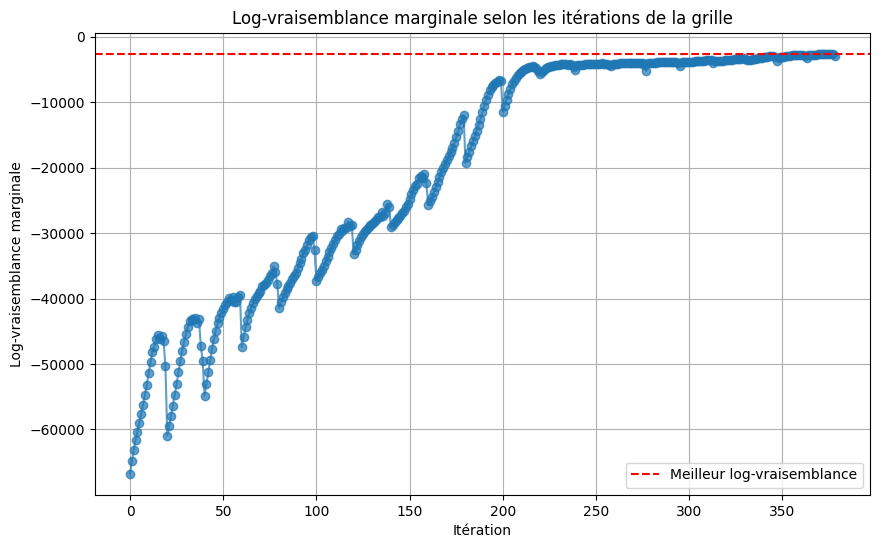

In [20]:
# Affichage du graphique d'itération
plt.figure(figsize=(10,6))
plt.plot(ll_values, marker='o', linestyle='-', alpha=0.7)
plt.axhline(best_ll, color='red', linestyle='--', label='Meilleur log-vraisemblance')
plt.title("Log-vraisemblance marginale selon les itérations de la grille")
plt.xlabel("Itération")
plt.ylabel("Log-vraisemblance marginale")
plt.legend()
plt.grid(True)
plt.show()


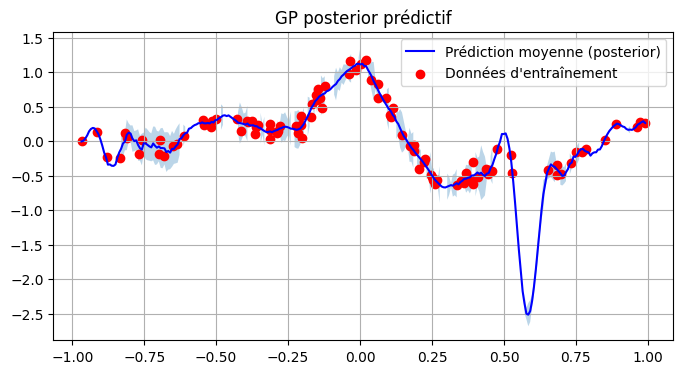

In [21]:
# Posteriori prédictive avec meilleurs paramètres
gamma_opt, c_opt = best_params
x = torch.linspace(train_X.min(), train_X.max(), 300)[:, None]
mu, cov = gp_posterior(x, train_X, train_y, gamma_opt, c_opt)

# Affichage
plt.figure(figsize=(8, 4))
plt.plot(x, mu, label='Prédiction moyenne (posterior)', color='blue')
plt.fill_between(x.flatten(), mu.flatten() - cov.diag().sqrt(), mu.flatten() + cov.diag().sqrt(), alpha=0.3)
plt.scatter(train_X, train_y, color='red', label='Données d\'entraînement')
plt.title("GP posterior prédictif")
plt.legend()
plt.grid()
plt.show()


### GP Predictive Posterior Visualization

The figure illustrates the predictive posterior of a Gaussian Process (GP) model trained on noisy observations. This visualization helps in understanding how the GP model captures both the trend in the data and the associated uncertainty.

In the graph, red dots represent the training data, which are noisy observations from an unknown function. The blue curve indicates the GP’s posterior predictive mean, reflecting the model's best estimate of the underlying function after observing the data. The light blue shaded region around the curve shows the model’s confidence interval, typically ±2 standard deviations. Narrower regions indicate higher confidence in the prediction, while wider regions reflect greater uncertainty.

### GP Model Steps

1. **Prior Definition**: The GP defines a prior over functions using a kernel, such as the squared exponential or RBF kernel, which encodes assumptions like smoothness and correlation length.
2. **Observation of Data**: Training data conditions the prior, resulting in a posterior distribution over functions.
3. **Posterior Prediction**: For each test point \( x \), the GP predicts a distribution \( \mathcal{N}(\mu(x), \sigma^2(x)) \), where the mean \( \mu(x) \) forms the blue curve and the variance \( \sigma^2(x) \) determines the confidence region.

### Model Behavior

The model exhibits low uncertainty in regions with many nearby data points, fitting closely to the data. In sparse or unseen regions, the model reverts to the prior, increasing the uncertainty and possibly returning to a mean of zero if the prior mean is zero. The shape of the curve, whether sharp or smooth, depends on kernel hyperparameters such as length scale and variance.




In [28]:
eigvals = torch.linalg.eigvalsh(K_test)
print(f"Min eigenvalue: {eigvals.min().item():.2e}")
print(f"Max eigenvalue: {eigvals.max().item():.2e}")
print(f"Condition number (max/min): {(eigvals.max() / eigvals.min()).item():.2e}")


Min eigenvalue: -1.79e+00
Max eigenvalue: 3.47e+00
Condition number (max/min): -1.94e+00


In [29]:
def robust_cholesky(K, max_attempts=10, initial_jitter=1e-5, jitter_factor=10.0):
    jitter = initial_jitter
    for attempt in range(max_attempts):
        try:
            K_jittered = K + torch.eye(K.shape[0]) * jitter
            L = torch.linalg.cholesky(K_jittered)
            return L
        except RuntimeError as e:
            print(f" Cholesky failed on attempt {attempt+1} with jitter={jitter:.1e}")
            jitter *= jitter_factor
    raise RuntimeError("Cholesky decomposition failed after multiple attempts.")

# Appliquer la méthode
L_test = robust_cholesky(K_test)
dist_test = MultivariateNormal(loc=mu_test.flatten(), scale_tril=L_test)

log_likelihood_test = dist_test.log_prob(test_y.flatten())
mse = torch.mean((mu_test.flatten() - test_y.flatten())**2)

print(f" Log-vraisemblance test : {log_likelihood_test.item():.4f}")
print(f" MSE test : {mse.item():.4f}")


 Cholesky failed on attempt 1 with jitter=1.0e-05
 Cholesky failed on attempt 2 with jitter=1.0e-04
 Cholesky failed on attempt 3 with jitter=1.0e-03
 Cholesky failed on attempt 4 with jitter=1.0e-02
 Cholesky failed on attempt 5 with jitter=1.0e-01
 Cholesky failed on attempt 6 with jitter=1.0e+00
 Log-vraisemblance test : -1039.1266
 MSE test : 0.1441


## Hyperparameter Optimization Results Analysis

### 1) Optimal Hyperparameters
The optimization process identified the following best hyperparameters:
- **Gamma (γ)**: 100.0
  - Gamma controls the influence of individual training samples. A high gamma value like 100.0 indicates that each training point has a significant influence on the model, which can lead to overfitting if not properly regularized.
- **C**: 5.4556
  - C is the regularization parameter. A moderate value suggests a balance between fitting the training data and preventing overfitting. However, this needs to be interpreted in conjunction with other results.

### 2) Model Evidence (Log-Marginal Likelihood)
The log-marginal likelihood is reported as -2590.5442.

**Implications**:
- This value serves as a measure of how well the model fits the training data, taking into account model complexity.
- The negative value is typical due to the logarithmic scale, but the magnitude suggests that the model might not be fitting the data optimally. A higher value (closer to zero) would indicate a better fit.

### 3) Eigenvalue Analysis
- **Minimum Eigenvalue**: -1.79
- **Maximum Eigenvalue**: 3.47
- **Condition Number**: -1.94

**Causes and Consequences**:
1. **Negative Eigenvalue**:
   - **Cause**: The presence of a negative eigenvalue indicates that the kernel matrix (or covariance matrix) is not positive definite. This can occur due to numerical precision issues, inappropriate kernel parameters, or noisy data.
   - **Consequence**: Many numerical methods, including Cholesky decomposition, require positive definite matrices. Negative eigenvalues can lead to numerical instability and unreliable model predictions.

2. **Condition Number**:
   - **Cause**: The negative condition number is unusual, as condition numbers are typically positive. This might indicate a miscalculation or misinterpretation. If we consider the absolute values, a condition number close to 2 suggests that the matrix is well-conditioned, but this contradicts the Cholesky failures and negative eigenvalues.
   - **Consequence**: If interpreted correctly, a low condition number indicates numerical stability. However, given other indicators of instability, this value might be misleading or incorrectly reported.


### 4) Overall Assessment 
**Root Causes**:
1. **Numerical Instability**:
   - The negative eigenvalues and Cholesky failures point to significant numerical instability, likely due to the high gamma value and possibly inappropriate kernel parameters.

2. **Hyperparameter Issues**:
   - The high gamma value might be causing overfitting and numerical instability by making the model too sensitive to individual data points.

**Recommendations**:
1. **Hyperparameter Tuning**:
   - Experiment with lower gamma values to reduce sensitivity to individual points and potentially improve numerical stability.
   - Adjust the regularization parameter C to better balance fit and complexity.

2. **Model Evaluation**:
   - While the MSE is moderately low, the numerical issues suggest that the model might not be reliable. Cross-validation and other diagnostic checks are recommended to ensure robustness.

### Conclusion
The results indicate a model with decent predictive performance (as indicated by MSE) but significant numerical instability issues. Addressing these stability problems through hyperparameter tuning, data preprocessing, and possibly alternative computational methods is a potential solution for improving the model's reliability and generalization capability.
²